Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Install and Import Libraries

In [ ]:
!pip install -q tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from collections import Counter


Load and Preprocess Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Teeth_Dataset"

train_dir = dataset_path + "/Training"
val_dir   = dataset_path + "/Validation"
test_dir  = dataset_path + "/Testing"


In [ ]:
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


Visualize Class Distribution (in training set)


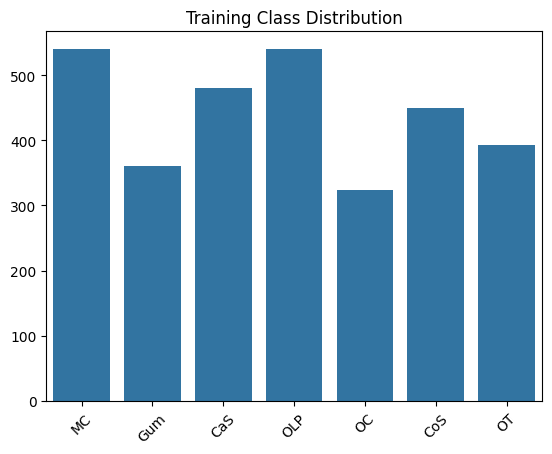

In [ ]:
labels = []
for images, label in train_ds:
    labels.extend(label.numpy())

label_counts = Counter(labels)
sns.barplot(x=[class_names[k] for k in label_counts.keys()], y=label_counts.values())
plt.title("Training Class Distribution")
plt.xticks(rotation=45)
plt.show()


Visualize Images Before and After Augmentation

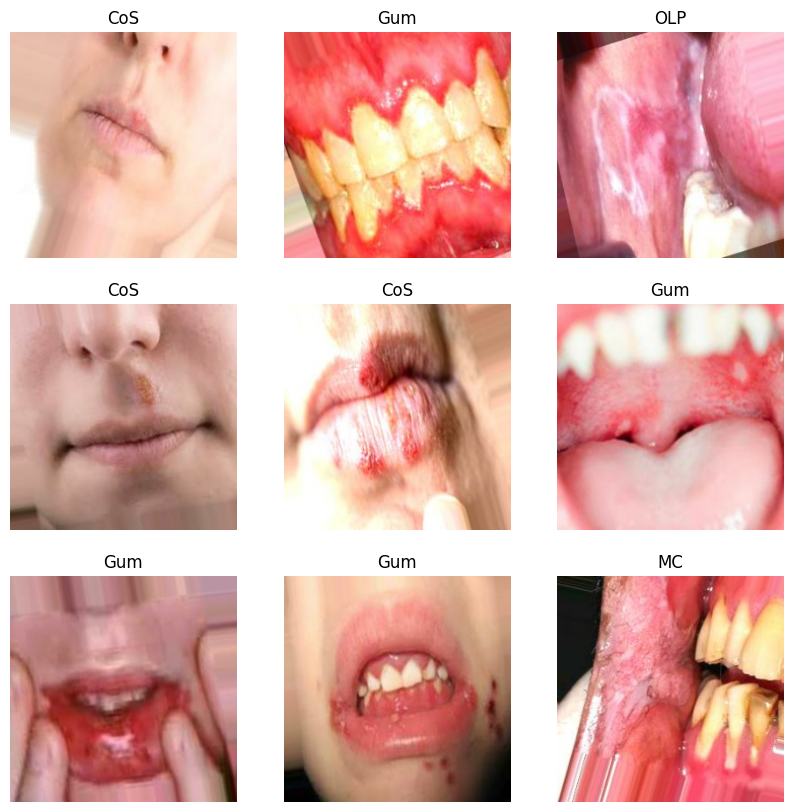

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


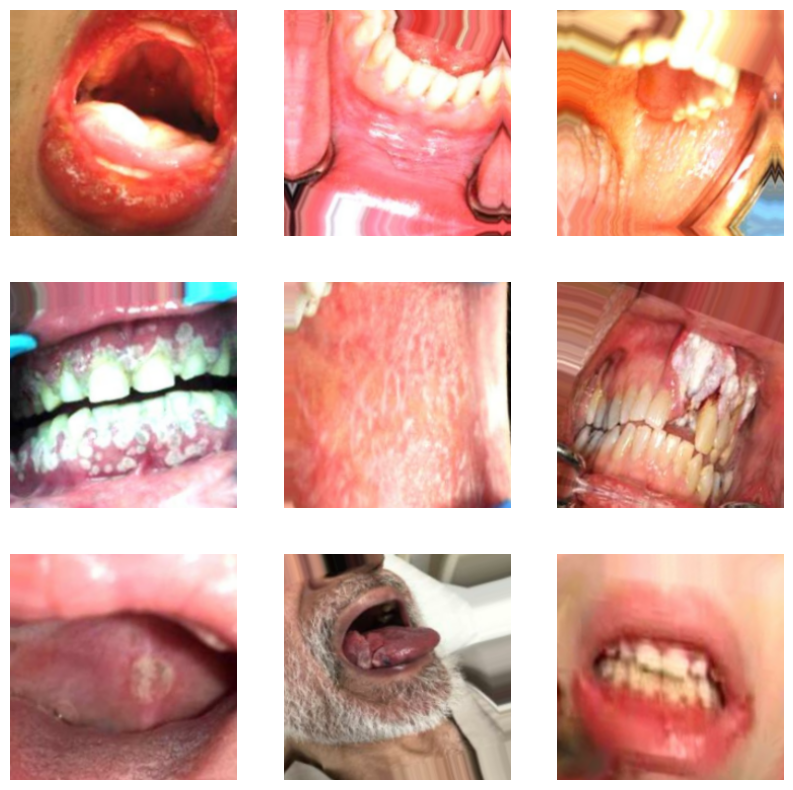

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")


Build Pretrained CNN (Transfer Learning with MobileNetV2)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (32, 7, 7, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (32, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 128)              │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 7)                │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [ ]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.2737 - loss: 2.0055 - val_accuracy: 0.6099 - val_loss: 1.1797
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5275 - loss: 1.2787 - val_accuracy: 0.6809 - val_loss: 0.9898
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5747 - loss: 1.1462 - val_accuracy: 0.7111 - val_loss: 0.8811
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.6005 - loss: 1.0632 - val_accuracy: 0.7529 - val_loss: 0.7463
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.6338 - loss: 0.9648 - val_accuracy: 0.7646 - val_loss: 0.7004
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.6719 - loss: 0.8931 - val_accuracy: 0.7860 - val_loss: 0.6371
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.6957 - loss: 0.8233 - val_accuracy: 0.8239 - val_loss: 0.5603
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.7126 - loss: 0.7666 - val_accu

Plot Learning Curves

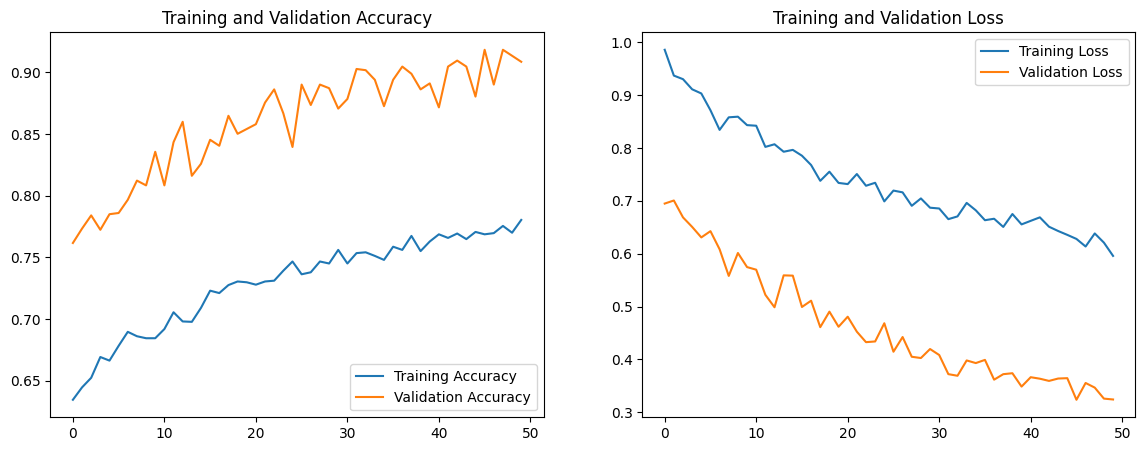

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
